In [76]:
import sys
!pip install skyfield

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load
from skyfield.api import Topos

In [77]:
planets = load('de422.bsp')

In [78]:
### choose place based off of Long and Lat
earth = planets['earth']
india = earth + Topos('20.5937 N', '78.9629 E')
names_of_planets = ['mercury', 'mars', 'venus', 'jupiter', 'saturn']
ts = load.timescale()

In [79]:
def planet_dataset_creator(year, planet, location):
    p = planets[planet + ' barycenter']
    
    columnslist = ["Alt", "Az", "Ra", "Dec", "Distance"]
    datelist = []
    rowslist = []
    for i in range(1, 13):
        t = ts.utc(year, i, 1)  #maybe put day at the end
        astrometric = location.at(t).observe(p)
        alt, az, _ = astrometric.apparent().altaz()        
        ra, dec, distance = astrometric.apparent().radec(epoch = "date")
        
        datelist.append(datetime.datetime(year, i, 1))
        rowslist.append({"Alt": alt.degrees, "Az": az.degrees, "Ra": ra.hours, "Dec": dec.degrees, "Distance": distance.km})
    return pd.DataFrame(rowslist, datelist, columnslist)

In [80]:
planet_dataset_creator(500, "mars", india)

,Alt,Az,Ra,Dec,Distance
0500-01-01 00:00:00,51.135207,120.272475,12.562675,-1.274108,1.909557e+08
0500-02-01 00:00:00,61.026670,152.671109,13.272290,-5.458231,1.447109e+08
0500-03-01 00:00:00,60.538056,202.070357,13.536516,-6.916631,1.088374e+08
0500-04-01 00:00:00,37.260655,246.010708,13.162670,-5.160539,8.503568e+07
0500-05-01 00:00:00,2.872194,266.161268,12.529998,-2.577262,8.629737e+07
0500-06-01 00:00:00,-26.604822,276.325689,12.494111,-3.744203,1.062797e+08
0500-07-01 00:00:00,-47.438866,280.387493,13.086077,-8.332338,1.318880e+08
0500-08-01 00:00:00,-63.637586,278.549296,14.106266,-14.676732,1.590222e+08
0500-09-01 00:00:00,-74.804531,266.449013,15.426975,-20.771258,1.854224e+08
0500-10-01 00:00:00,-80.487202,243.139921,16.937578,-24.632755,2.105527e+08


In [81]:
class Astonomer:
    def __init__(self, measure_error):
        # Measure_error is a mapping between each measure and the maximum error
        self.measure_error = measure_error
        
    def generate_data(self, year, planet, location):
        p = planets[planet + ' barycenter']

        columnslist = self.measure_error.keys()
        datelist = []
        rowslist = []
        for i in range(1, 13):
            t = ts.utc(year, i, 1)  #maybe put day at the end
            astrometric = location.at(t).observe(p)
            alt, az, _ = astrometric.apparent().altaz()        
            ra, dec, distance = astrometric.apparent().radec(epoch = "date")
            
            finalRow = {}
            if "Alt" in columnslist:
                std = self.measure_error["Alt"] / 3 #3 SD's, unlikely to have higher than maximum error in either direction
                finalRow["Alt"] = alt.degrees + np.random.normal(0, std)
            if "Az" in columnslist:
                std = self.measure_error["Az"] / 3 
                finalRow["Az"] = az.degrees + np.random.normal(0, std)
            if "Ra" in columnslist:
                std = self.measure_error["Ra"] / 3 
                finalRow["Ra"] = ra.hours + np.random.normal(0, std)
            if "Dec" in columnslist:
                std = self.measure_error["Dec"] / 3 
                finalRow["Dec"] = dec.degrees + np.random.normal(0, std)
            if "Distance" in columnslist:
                std = self.measure_error["Distance"] / 3 
                finalRow["Distance"] = distance.km + np.random.normal(0, std)
            datelist.append(datetime.datetime(year, i, 1))
            rowslist.append(finalRow)
        return pd.DataFrame(rowslist, datelist, columnslist)

In [82]:
astrolabe = Astronomer({"Alt":2})
crossStaff = Astronomer({"Alt":5/60})

In [83]:
astrolabe.generate_data(500, "mars", india)

,Alt
0500-01-01 00:00:00,50.699751
0500-02-01 00:00:00,60.525397
0500-03-01 00:00:00,60.674937
0500-04-01 00:00:00,37.069081
0500-05-01 00:00:00,1.392240
0500-06-01 00:00:00,-26.297201
0500-07-01 00:00:00,-47.337051
0500-08-01 00:00:00,-63.888085
0500-09-01 00:00:00,-75.202630
0500-10-01 00:00:00,-80.341093


In [84]:
crossStaff.generate_data(500, "mars", india)

,Alt
0500-01-01 00:00:00,51.112686
0500-02-01 00:00:00,61.038199
0500-03-01 00:00:00,60.437786
0500-04-01 00:00:00,37.301501
0500-05-01 00:00:00,2.882172
0500-06-01 00:00:00,-26.629941
0500-07-01 00:00:00,-47.424326
0500-08-01 00:00:00,-63.688651
0500-09-01 00:00:00,-74.812834
0500-10-01 00:00:00,-80.529303


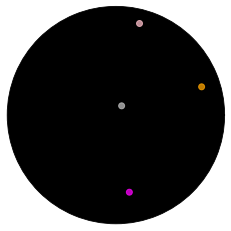

In [89]:
def createFrame(planets, filename = None):
    plt.rcParams['axes.facecolor'] = 'black'
    azimuths = [planets[planet][1] for planet in planets]
    theta = [90 - planets[planet][1] for planet in planets]
    r = [90 - planets[planet][0] for planet in planets]
    colors =["silver", "pink", "red", "orange", "magenta"]
    
    for i, azimuth in enumerate(reversed(azimuths)):
        if(azimuth < 0):
            del theta[i]
            del r[i]
            del colors[i]
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    ax.set_rlim(0,100)
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    c = ax.scatter(theta, r, c=colors, cmap='hsv', alpha=0.75)
    
    if filename:
        plt.savefig(str(filename) + '.png')
    
    
planets = {'Mercury': (80,45), 'Venus': (3,7), 'Mars': (45, -10), 'Jupiter': (7,8), 'Saturn': (18,16)}
createFrame(planets)

In [ ]:
def create_master_dataset(measurement_error, start_time, timestep, number_of_timesteps, planets, location, images = False):
    